In [ ]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

simplefilter('ignore')

# Set matplotlib default
plt.style.use("ggplot")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight="bold"
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv(
    "/content/us-retail-sales.csv",
    usecols=['Month'] + industries,    ## Only load the 'Month' column and columns listed in 'industries'
    parse_dates=['Month'],     #  Automatically parse 'Month' as date type
    index_col='Month'   #  Set 'Month' column as the index of the DataFrame
)
retail = retail.to_period('D')   #  Convert the DateTime index into a daily PeriodIndex
retail = retail.reindex(columns=industries)       # Make sure the DataFrame only has the specified industries as columns
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

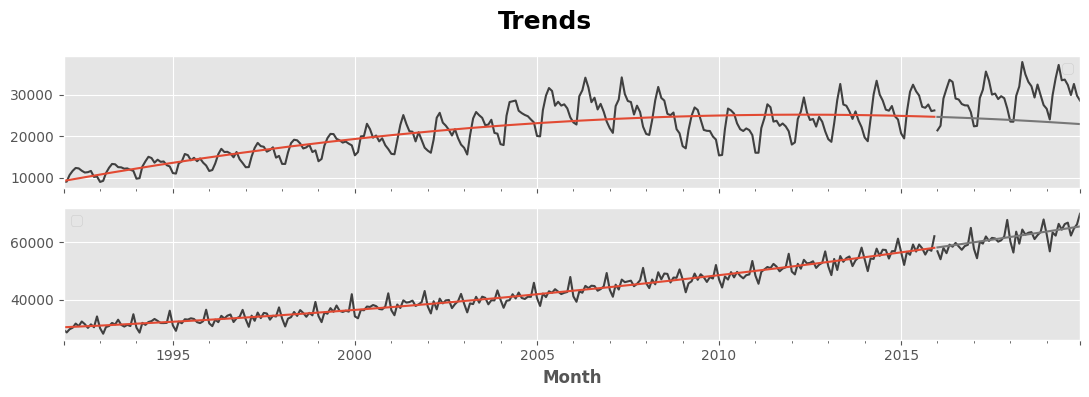

In [ ]:
# Make a copy of the retail sales data. (y will be our target: what we want to predict.)
y = retail.copy()

# Create trend features
dp = DeterministicProcess(
    index=y.index,    # Set the dates as the index for the trend features
    constant=True,      # Add a constant (bias) feature
    order=2,
    drop=True
)

# Create the trend feature based on the dates
X = dp.in_sample()

# Split data into training and testing sets
idx_train, idx_test = train_test_split(
    y.index, test_size=12 * 4, shuffle=False
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]   # Use the split indexes to create X_train, X_test, y_train, y_test
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit trend model
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)        # Train (fit) the model on the training data


# Make predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns
)

# Plot
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)

for ax in axs: ax.legend([])  # remove legend
_ = plt.suptitle("Trends")

In [ ]:
# The stack method convert column labels to row labels, pivoting from wide format to long
X = retail.stack()   # pivot dataset wide to long
display(X.head())
y = X.pop('Sales')    # grab target series

Sales
Month      Industries              
1992-01-01 BuildingMaterials   8964
           FoodAndBeverage    29589
1992-02-01 BuildingMaterials   9023
           FoodAndBeverage    28570
1992-03-01 BuildingMaterials  10608

In [ ]:
# Turn row labels into categorical feature columns with label encoding
# Move 'Industries' from the index into a normal column (so we can work with it as a feature)
X = X.reset_index('Industries')

# Label encoding for 'Industries' feature
for col in X.select_dtypes(["object", "category"]):
  X[col], _ = X[col].factorize()

# Label encoding for annaal seasonality
X["Month"] = X.index.month    # values are 1, 2, 3, 4, ..... 12

# Create splits
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [ ]:
# Pivot wide to long (stack) and convert dataframe to series (squeeze)
y_fit = y_fit.stack().squeeze()   # trend from training set
y_pred = y_pred.stack().squeeze()   # trend from test set

# Create residuals (collection of the detrended seires) from the training set
y_resid = y_train - y_fit

# Train XGBoost on the residuals
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Add the predicted residual onto the predicted trends
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

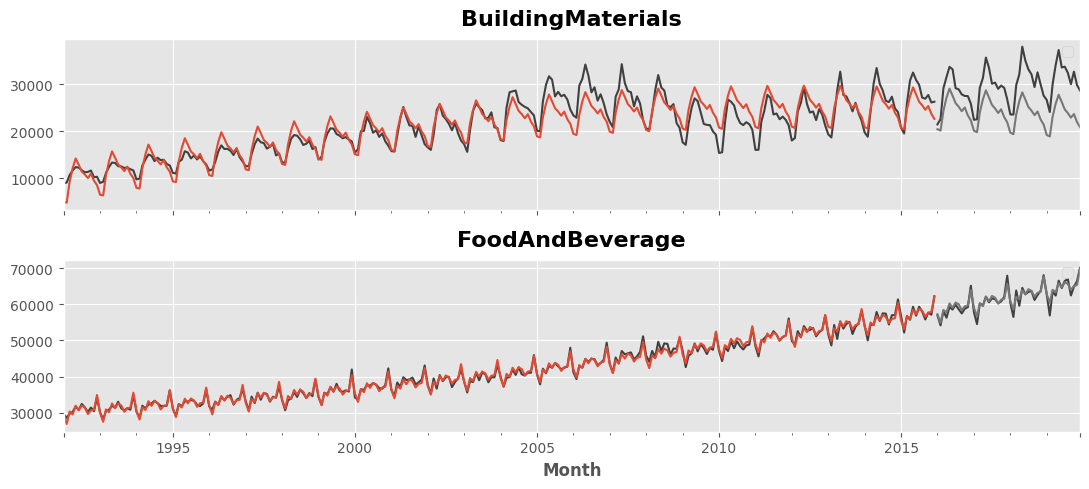

In [ ]:
axs = y_train.unstack(['Industries']).plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
    title=['BuildingMaterials', 'FoodAndBeverage']
)

axs = y_test.unstack(['Industries']).plot(
    color='0.25', subplots=True, sharex=True, ax=axs
)

axs = y_fit_boosted.unstack(['Industries']).plot(
    color='C0', subplots=True, sharex=True, ax=axs
)

axs = y_pred_boosted.unstack(['Industries']).plot(
    color='C3', subplots=True, sharex=True, ax=axs
)
for ax in axs: ax.legend([])

1. Linear Regression can handle multi-output regression easily:
That means it can predict many series at once (e.g., sales for Clothes, Food, Electronics all at the same time).

It just learns a formula for each output.

✅ No problem!

2. XGBoost cannot handle multi-output directly:
XGBoost expects only one target (one thing to predict) at a time.

It cannot predict multiple series in a single model run.

❌ So, you need a trick.

3. The Trick: Wide to Long Format
Your data is usually in wide format:
(Each column is a different series.)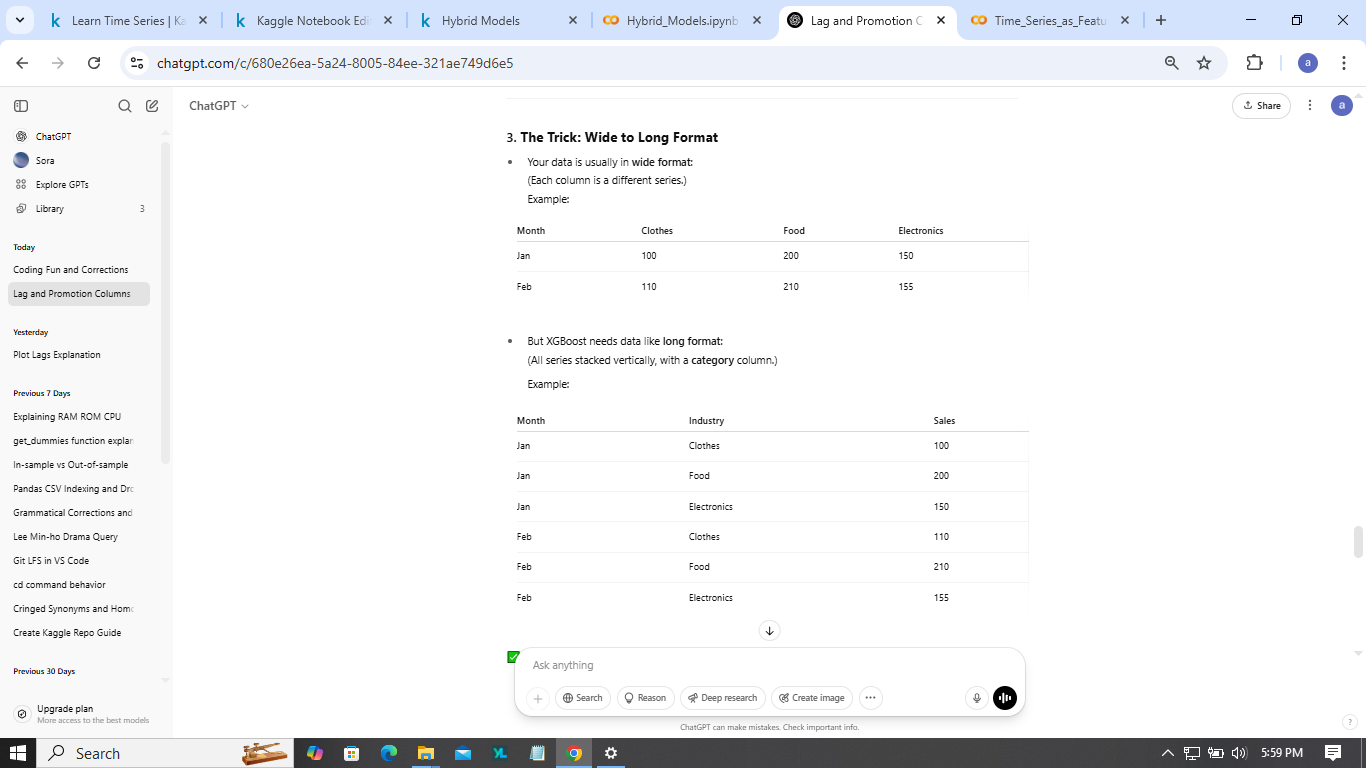

1. Turning "Industries" into a Categorical Feature
In the long format data we created earlier, the Industry column has the values like Clothes, Food, and Electronics.

To make XGBoost understand these as categories (instead of just strings), we convert the Industries into numeric labels using Label Encoding.

Why Label Encoding?
XGBoost works better with numerical data.

Instead of treating "Clothes" as a string, XGBoost treats it as a number (like 0), which helps it process faster and more effectively.

2. Adding a Feature for Annual Seasonality (Month Numbers)
Time series often have seasonal patterns: for example, retail sales might go up in December (holiday season), or fall in summer.

We can extract the month number from the time index (January = 1, February = 2, …) and use it as a feature. This way, XGBoost can learn the seasonality pattern in the data.

Full Process:
Label Encode "Industry": Convert "Clothes" → 0, "Food" → 1, "Electronics" → 2.

Add Month Numbers: Create a feature based on the month number (1 = January, 2 = February, …).

This way, XGBoost can learn:

How different industries affect sales.

How the season (time of the year) affects sales.